In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from modules.BatchPitNormalization import BatchPitNorm1d
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")


Using cuda device


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = np.genfromtxt('data/housing.csv', delimiter=",",skip_header=1)

data = np.delete(data, [-1], axis=1)


X = data[:,:8]
Y = data[:,8].reshape(-1,1)



Y=Y[~np.isnan(X).any(axis=1)]
X=X[~np.isnan(X).any(axis=1)]


X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, shuffle = True)

scalerX = StandardScaler()
scalerY = StandardScaler()
# scale
scaler_x = scalerX.fit(X_train_raw)
scaler_y = scalerY.fit(y_train_raw)

X_train = scaler_x.transform(X_train_raw)
X_test = scaler_x.transform(X_test_raw)


y_train = scaler_y.transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device).reshape(-1,1)



In [31]:
#without bn
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_function):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)
        self.activation_function = activation_function
        #self.bn = nn.BatchNorm1d(hidden_size)
 
    def forward(self, x):
        #x = self.activation_function(self.bn((self.layer1(x))))
        x = self.activation_function(self.layer1(x))
        x = self.activation_function(self.layer2(x))
        x = self.layer3(x)
        return x

In [32]:
# with bn
class NeuralNetwork2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_function):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)
        self.activation_function = activation_function
        self.bn = nn.BatchNorm1d(hidden_size)
 
    def forward(self, x):
        x = self.activation_function(self.bn((self.layer1(x))))
        x = self.activation_function(self.bn((self.layer2(x))))
        x = self.layer3(x)
        return x

In [33]:
# Define the model
# not used

model1 = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

model2 = nn.Sequential(
    nn.Linear(8, 24),
    nn.BatchNorm1d(24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.BatchNorm1d(12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.BatchNorm1d(6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
model1.cuda()
model2.cuda()


Sequential(
  (0): Linear(in_features=8, out_features=24, bias=True)
  (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=24, out_features=12, bias=True)
  (4): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=6, bias=True)
  (7): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=6, out_features=1, bias=True)
)

Training with ReLU activation function...


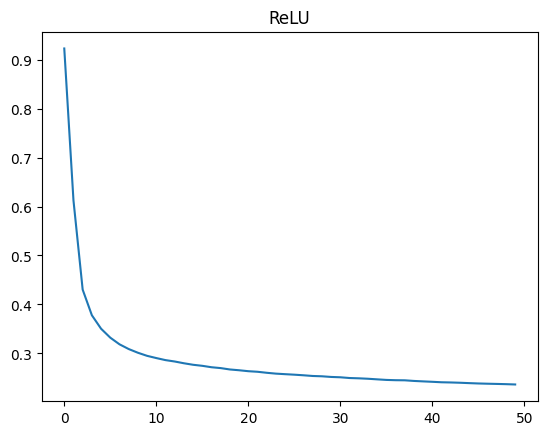

Training with Sigmoid activation function...


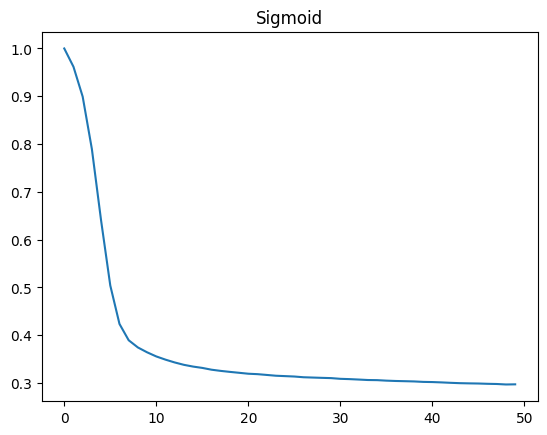

Training with Tanh activation function...


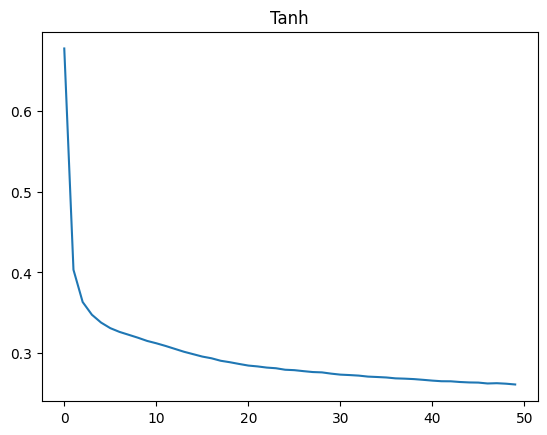

In [34]:

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}
input_size = 8
hidden_size = 32
num_classes = 1
learning_rate = 0.0003 #0.001
n_epochs = 50 #100
batch_size = 128 # 64

# test different activation functions
for name, activation_function in activation_functions.items():
    print(f"Training with {name} activation function...")
    loss_values = []
    model = NeuralNetwork(input_size, hidden_size, num_classes, activation_function).to(device)
    model.cuda()
    lossFunction = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=batch_size)
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for Xbatch, ybatch in loader:
            y_pred = model(Xbatch)
            loss = lossFunction(y_pred, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #print(loss.item())
            running_loss += loss.item()
        loss_values.append(running_loss/len(loader))
    

    plt.figure()
    plt.plot(loss_values)
    plt.title(name)
    plt.show()
    
    model.eval()
  # evaluation...